In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from dateutil.parser import parse
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt

C:\Users\peter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###TODO: expand to full data, figure out how to visualize the difference in compounds or just train multiple neural networks on each compound, fix the size error idk why thats happening

In [3]:
filenames = ["LapWeather_Australian Grand Prix.csv","LapWeather_Austrian Grand Prix.csv","LapWeather_Azerbaijan Grand Prix.csv","LapWeather_Bahrain Grand Prix.csv","LapWeather_Belgian Grand Prix.csv","LapWeather_Brazilian Grand Prix.csv","LapWeather_British Grand Prix.csv","LapWeather_Canadian Grand Prix.csv", "LapWeather_Chinese Grand Prix.csv","LapWeather_French Grand Prix.csv","LapWeather_German Grand Prix.csv","LapWeather_Hungarian Grand Prix.csv","LapWeather_Italian Grand Prix.csv","LapWeather_Japanese Grand Prix.csv","LapWeather_Mexican Grand Prix.csv","LapWeather_Monaco Grand Prix.csv","LapWeather_Russian Grand Prix.csv","LapWeather_Singapore Grand Prix.csv","LapWeather_Spanish Grand Prix.csv","LapWeather_United States Grand Prix.csv"]
combined_csv = pd.concat([pd.read_csv(f) for f in filenames ])
print(combined_csv)
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

     Unnamed: 0                    Time  DriverNumber                 LapTime  \
0             0  0 days 00:08:44.363000             5                     NaN   
1             1  0 days 00:10:14.925000             5  0 days 00:01:30.562000   
2             2  0 days 00:11:45.102000             5  0 days 00:01:30.177000   
3             3  0 days 00:13:14.712000             5  0 days 00:01:29.610000   
4             4  0 days 00:14:44.252000             5  0 days 00:01:29.540000   
..          ...                     ...           ...                     ...   
926         926  0 days 02:02:52.173000            20  0 days 00:01:40.578000   
927         927  0 days 02:04:32.739000            20  0 days 00:01:40.566000   
928         928  0 days 02:06:13.291000            20  0 days 00:01:40.552000   
929         929  0 days 02:07:54.121000            20  0 days 00:01:40.830000   
930         930  0 days 02:09:37.534000            20  0 days 00:01:43.413000   

     LapNumber             

In [4]:
df = pd.read_csv('combined_csv.csv')
df = df[df["IsAccurate"]==True]
df = df[df["TrackStatus"]==1]
df = df.drop(['Time','DriverNumber','WindDirection','LapStartDate', 'Unnamed: 0', 'PitOutTime', 'PitInTime', 'Sector1Time','Sector2Time','Sector3Time','Sector1SessionTime','Sector2SessionTime','Sector3SessionTime','SpeedI1','SpeedI2','SpeedST','IsPersonalBest','FreshTyre','SpeedFL','LapStartTime','Driver','TrackStatus','IsAccurate'], axis=1)
df = df.dropna()
dfOutput = df['LapTime']
train_targets = dfOutput.to_numpy()

for i in range(len(train_targets)):
    train_targets[i] = train_targets[i].replace('0 days ', '')
# print(train_targets)
actual_train_targets = []
for time in train_targets:
    td = parse(time) - parse('00:00:00')
    seconds = td.total_seconds()
    actual_train_targets.append(seconds)
# print(actual_train_targets)
dfLapTime = pd.DataFrame(actual_train_targets)

df['LapTime'] = dfLapTime
df = df.dropna()
cols = ['LapTime']
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3-Q1
df = df[(~(df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
dfInput = df.drop(['LapTime'], axis=1)
dfInput = dfInput.replace({'SUPERHARD':1, 'HARD':2, 'MEDIUM':3, 'SOFT':4,'SUPERSOFT': 5, 'ULTRASOFT': 6,'HYPERSOFT':7,"INTERMEDIATE":0,"WET":-1})
dfInput = dfInput.replace({'Ferrari':1,'Mercedes':2,'Red Bull Racing':3, 'McLaren':4, 'Renault':5, 'Force India':6, 'Sauber':7, 'Williams':8, 'Toro Rosso':9, 'Haas F1 Team':10, 'Racing Point':6})
print(dfInput)
train_inputs = dfInput.to_numpy()
inputs_array = train_inputs.astype('float64')
dfOutput = df['LapTime']
targets_array = dfOutput.to_numpy()
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

new_shape = (len(targets_array), 1)
targets = targets.view(new_shape)
print(targets.shape)

print(inputs_array)
print(targets_array)


       LapNumber  Compound  TyreLife  Stint  Team  AirTemp  Humidity  \
1              2         6       4.0    1.0     1     24.2      36.3   
2              3         6       5.0    1.0     1     23.9      36.5   
3              4         6       6.0    1.0     1     23.9      36.3   
4              5         6       7.0    1.0     1     23.5      36.3   
7              8         6      10.0    1.0     1     23.8      35.6   
...          ...       ...       ...    ...   ...      ...       ...   
17253         63         6      50.0    2.0     9     26.2      57.1   
17254         64         6      51.0    2.0     9     26.2      57.0   
17255         65         6      52.0    2.0     9     26.2      57.0   
17256         66         6      53.0    2.0     9     26.1      57.1   
17257         67         6      54.0    2.0     9     25.9      58.1   

       Pressure  Rainfall  TrackTemp  WindSpeed  Track  
1         996.9     False       38.2        3.8      1  
2         997.1     F

In [5]:
dataset = TensorDataset(inputs, targets)

In [6]:
val_percent = 0.2
num_rows = len(dfInput.index)
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [7]:
batch_size = 11
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_ds, batch_size, num_workers = 0)

In [8]:
input_size = len(inputs[0])
output_size = 1

In [9]:
class MultiLinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(12, 144),
            nn.ReLU(),
            nn.Linear(144,72),
            nn.ReLU(),
            nn.Linear(72,36),
            nn.ReLU(),
            nn.Linear(36,1),
            
        )
        
    def forward(self, xb):
        out = self.layers(xb)                       
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        mse_loss = nn.MSELoss()
        # cross_entropy_loss = nn.CrossEntropyLoss()
        # loss = cross_entropy_loss(out, targets)
        loss = mse_loss(out, targets)  
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        mse_loss = nn.MSELoss()
        loss = mse_loss(out, targets)    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [10]:
model = MultiLinearRegressionModel()

In [11]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0520, -0.0808, -0.0943,  ..., -0.1701, -0.0341, -0.0260],
         [-0.2168, -0.1096, -0.2676,  ..., -0.2542,  0.2142,  0.0961],
         [ 0.1100, -0.0610,  0.0044,  ...,  0.0103, -0.2858,  0.1801],
         ...,
         [ 0.1633,  0.0626,  0.2484,  ...,  0.1926,  0.0140,  0.0367],
         [-0.1132, -0.2097, -0.2297,  ...,  0.1610,  0.0157, -0.1834],
         [ 0.2359, -0.0273, -0.0960,  ...,  0.1792,  0.2502, -0.0036]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0388, -0.2460,  0.2144, -0.1048, -0.0515,  0.2539, -0.1757,  0.1061,
         -0.2131, -0.0406, -0.2752, -0.2528,  0.1553, -0.0443,  0.0552, -0.2385,
          0.2718,  0.0589, -0.1909, -0.1655,  0.2431,  0.0820, -0.2053,  0.1630,
          0.0033, -0.2505, -0.1704, -0.0293,  0.1613,  0.2216, -0.1052, -0.0766,
          0.0890, -0.0306,  0.0634,  0.1775, -0.0238,  0.2449, -0.0651,  0.2631,
          0.0679,  0.1781, -0.1036,  0.2550,  0.0038,  0.2198, -0.2651, -0.1349

In [12]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [13]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 7785.0595703125}


In [14]:
epochs = 10000
lr = 1e-6
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 188.1121
Epoch [40], val_loss: 176.1656
Epoch [60], val_loss: 171.5912
Epoch [80], val_loss: 165.1456
Epoch [100], val_loss: 158.0972
Epoch [120], val_loss: 175.4297
Epoch [140], val_loss: 129.1278
Epoch [160], val_loss: 132.3193
Epoch [180], val_loss: 102.8234
Epoch [200], val_loss: 101.0723
Epoch [220], val_loss: 103.8352
Epoch [240], val_loss: 116.2396
Epoch [260], val_loss: 106.2146
Epoch [280], val_loss: 91.3781
Epoch [300], val_loss: 104.1678
Epoch [320], val_loss: 101.5275
Epoch [340], val_loss: 98.8125
Epoch [360], val_loss: 85.1743
Epoch [380], val_loss: 81.7113
Epoch [400], val_loss: 82.0718
Epoch [420], val_loss: 110.3524
Epoch [440], val_loss: 93.4614
Epoch [460], val_loss: 88.1632
Epoch [480], val_loss: 81.8158
Epoch [500], val_loss: 80.1376
Epoch [520], val_loss: 77.9182
Epoch [540], val_loss: 102.6259
Epoch [560], val_loss: 81.5976
Epoch [580], val_loss: 89.2156
Epoch [600], val_loss: 83.4053
Epoch [620], val_loss: 82.2969
Epoch [640], val_loss: 79.

In [23]:
torch.save(model.state_dict(), 'laptime_model.pth')

In [24]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                
    prediction = predictions[0].detach()
    return target, prediction

In [27]:
input, target = val_ds[12]
predict_single(input, target, model)


(tensor([110.3370]), tensor([106.4680]))

In [26]:
input, target = val_ds[50]
predict_single(input, target, model)

(tensor([83.9730]), tensor([81.1919]))

In [28]:
def get_accuracy(predict,actual):
        predict = predict.detach().numpy()
        actual = actual.numpy()

        count = 0

        for i in range(len(actual)):
            if predict[i] >= actual[i]*.90 and predict[i] <= actual[i]*1.1:
                count+=1
        return count/len(predict)*100


In [29]:
targets = []
predictions = []
for i in range(len(val_ds)):
    input, target = val_ds[i]
    target, prediction = predict_single(input, target, model)
    # np.append(targets,target)
    targets.append(target)
    predictions.append(prediction)
    # np.append(predictions,prediction)

# print(len(predictions))
# print(targets[0])
accuracy = []
for j in range(len(predictions)-1):
    accuracy.append(get_accuracy(predictions[j],targets[j]))

In [30]:
print(np.sum(accuracy)/len(accuracy))

28.394612304332


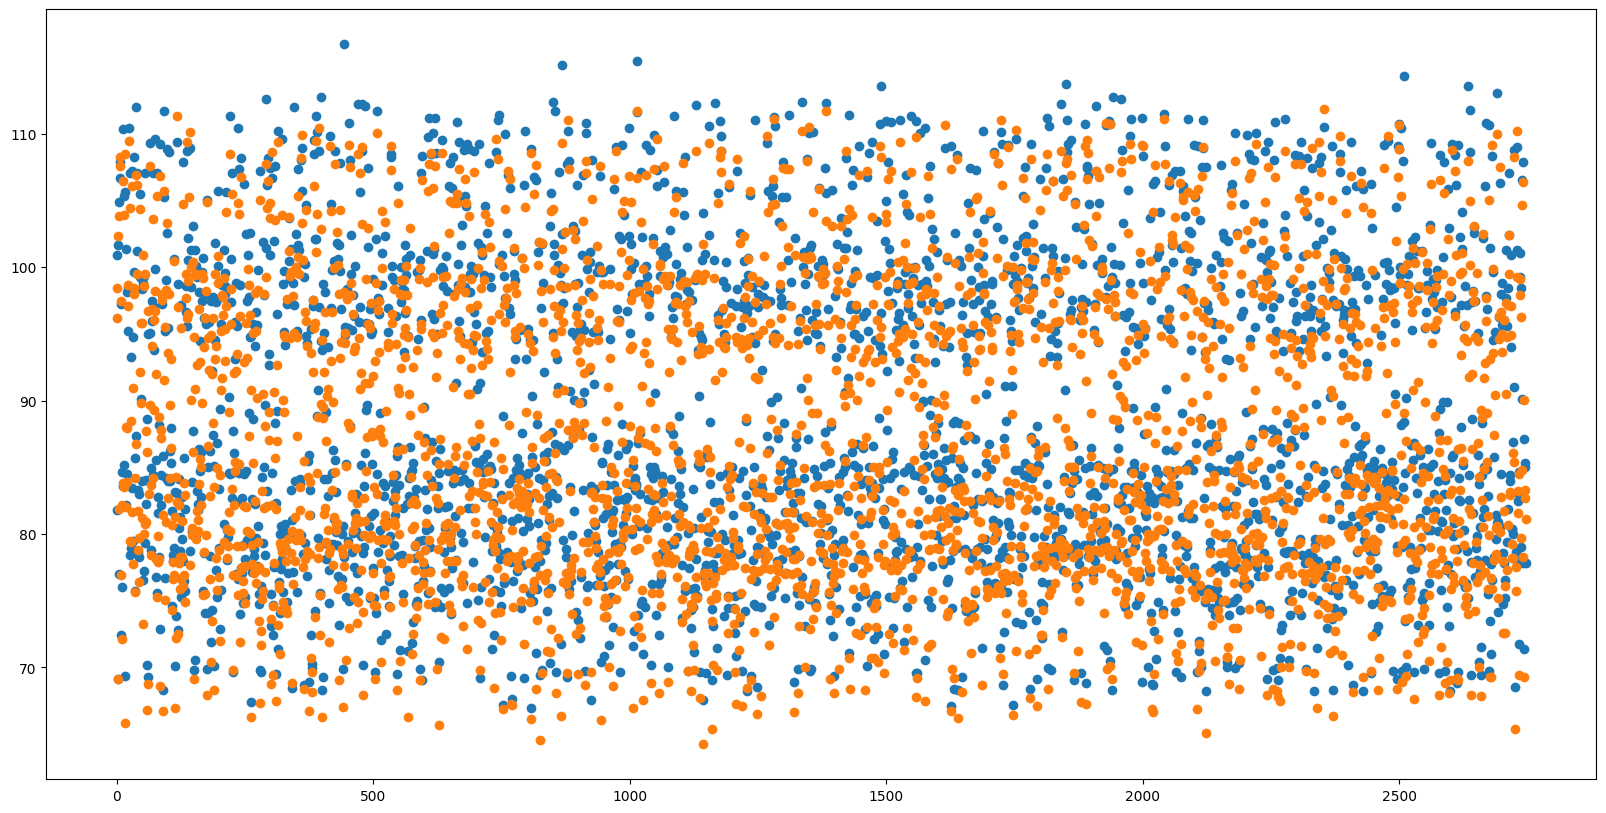

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.scatter(range(len(predictions)),targets)
ax.scatter(range(len(predictions)), predictions)
